In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from PIL import Image
from pathlib import Path
import os
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight


In [ ]:
# Caminho do dataset
DATASET_PATH = "/content/drive/MyDrive/garbage_classifcat"

In [ ]:
# Montar o Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Listar arquivos do diretório
image_dir = Path(DATASET_PATH)
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

In [ ]:
# Criar DataFrame
df = pd.DataFrame({'Filepath': filepaths, 'Label': labels})
df['Filepath'] = df['Filepath'].astype(str)

In [ ]:
# Divisão em treino e teste
train_df, test_df = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)

In [ ]:
# Geradores de dados com Data Augmentation
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    brightness_range=[0.4, 1.6],
    zoom_range=0.3,
    horizontal_flip=True,
    shear_range=0.2,
    channel_shift_range=0.2
)

val_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2],
    zoom_range=0.2,
    horizontal_flip=True
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_images = val_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

test_images = val_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 5120 validated image filenames belonging to 4 classes.
Found 1280 validated image filenames belonging to 4 classes.
Found 1600 validated image filenames belonging to 4 classes.


In [ ]:
# Balanceamento das classes
class_weights = compute_class_weight('balanced', classes=np.unique(df['Label']), y=df['Label'])
class_weights = dict(enumerate(class_weights))

In [ ]:
# Carregar modelo pré-treinado
pretrained_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet', pooling='avg')
pretrained_model.trainable = True


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Congelar apenas as primeiras 100 camadas
for layer in pretrained_model.layers[:100]:
    layer.trainable = False


In [ ]:
# Construção do modelo
inputs = pretrained_model.input
x = tf.keras.layers.Dense(512, activation='relu')(pretrained_model.output)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.4)(x)  # Aumento do dropout
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.4)(x)
outputs = tf.keras.layers.Dense(len(train_images.class_indices), activation='softmax')(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=Adam(learning_rate=3e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Callbacks
checkpoint_path = "model_resolid.weights.h5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_weights_only=True, monitor="val_accuracy", save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=80, restore_best_weights=True)

In [ ]:
# Treinamento do modelo
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=20,
    class_weight=class_weights,
    callbacks=[early_stopping, checkpoint_callback]
)

NameError: name 'model' is not defined

In [ ]:
# Conversão para TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

Saved artifact at '/tmp/tmp8tnxx9qi'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  137500535523664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137500535523280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137500535527504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137500535527120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137500535525968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137500535527696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137500535526736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137500535523472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137500535527888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137500535525776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13750053552827

In [ ]:
# Avaliação do modelo
results = model.evaluate(test_images, verbose=0)
print(f"Test Loss: {results[0]:.5f}")
print(f"Test Accuracy: {results[1] * 100:.2f}%")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Test Loss: 0.31395
Test Accuracy: 90.19%


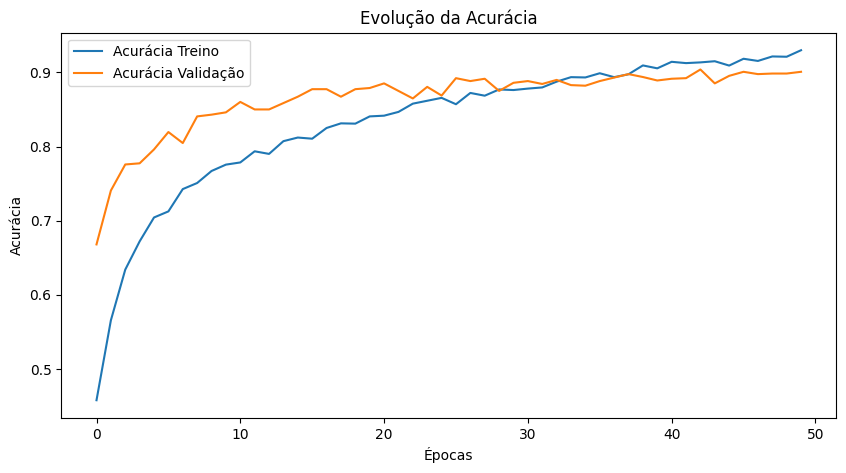

In [ ]:
# Análise de Overfitting
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(10, 5))
plt.plot(train_acc, label='Acurácia Treino')
plt.plot(val_acc, label='Acurácia Validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.title('Evolução da Acurácia')
plt.show()

In [ ]:
# Verificar se há overfitting
acc_diff = np.array(train_acc) - np.array(val_acc)
if max(acc_diff) > 0.1:
    print("Possível overfitting detectado: Acurácia de treino significativamente maior que validação.")
else:
    print("Modelo parece bem equilibrado entre treino e validação.")

Modelo parece bem equilibrado entre treino e validação.


In [ ]:
# Salvar modelo completo em formato .h5
model.save("modelo_treinado.h5")

# Salvar modelo convertido para TensorFlow Lite
with open("modelo_treinado.tflite", "wb") as f:
    f.write(tflite_model)

# Disponibilizar para download no Google Colab
from google.colab import files
files.download("modelo_treinado.h5")
files.download("modelo_treinado.tflite")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>